In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### what to do next
- decoder/dict_atoms -> sae_hidden x mlp_dim
- relu_acts -> sae_hidden
- out -> mlp_dim

- concat(samples X filtered_sae_hidden) x mlp_dim
- einop('s f m -> (s f) m')
- PCA of that stuff

In [2]:
sae_dict = torch.load("sae_model.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

model_dict = torch.load("modular_arithmetic_model.pth", map_location=device)
model = man.OneLayerTransformer(p=113, d_model=128, nheads=4).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [3]:
torch.manual_seed(1337)
# generate combination of all inputs a and b range (113)
a = np.arange(113)
b = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a for b_i in b])
inputs = torch.tensor(inputs).to(device)  # Add batch dimension
print(inputs.shape)
logits, activations = model(inputs, return_activations=True)
activations_data = activations[:, -1, :].detach()
batched_acts = activations_data.unsqueeze(0).repeat(5, 1, 1).to(device)
del model, model_dict
print(batched_acts.shape)

torch.Size([12769, 4])
torch.Size([5, 12769, 512])


In [4]:
import pickle

decoder = sae.W_d[3].detach()
print(decoder.shape)
_, _, feat_acts, _ = sae(batched_acts)
features = feat_acts[3].detach()
with open("sae_clusters.pkl", "rb") as f:
    clusters = pickle.load(f)
clusters = [c for c in clusters if len(c) > 1]  # Filter out clusters with only one element
clusters = sorted(clusters, key=lambda x: len(x), reverse=True)  # Sort by size
print(features.shape)


torch.Size([2048, 512])
torch.Size([12769, 2048])


In [38]:
print(len(clusters[3]))

45


In [30]:
features_interest = features[:, clusters[3]]
decoder_interest = decoder[clusters[3], :]
reconstructions = features_interest @ decoder_interest
reconstructions.shape

torch.Size([12769, 512])

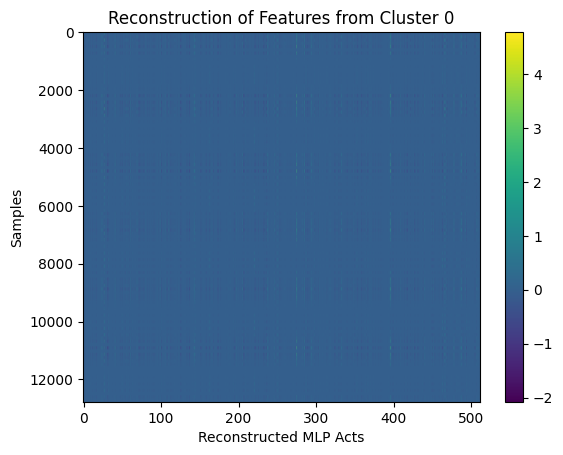

In [31]:
#imshow reconstructions
plt.imshow(reconstructions.cpu().numpy(), aspect='auto')
plt.title("Reconstruction of Features from Cluster 0")
plt.xlabel("Reconstructed MLP Acts")
plt.ylabel("Samples")
plt.colorbar()
plt.show()

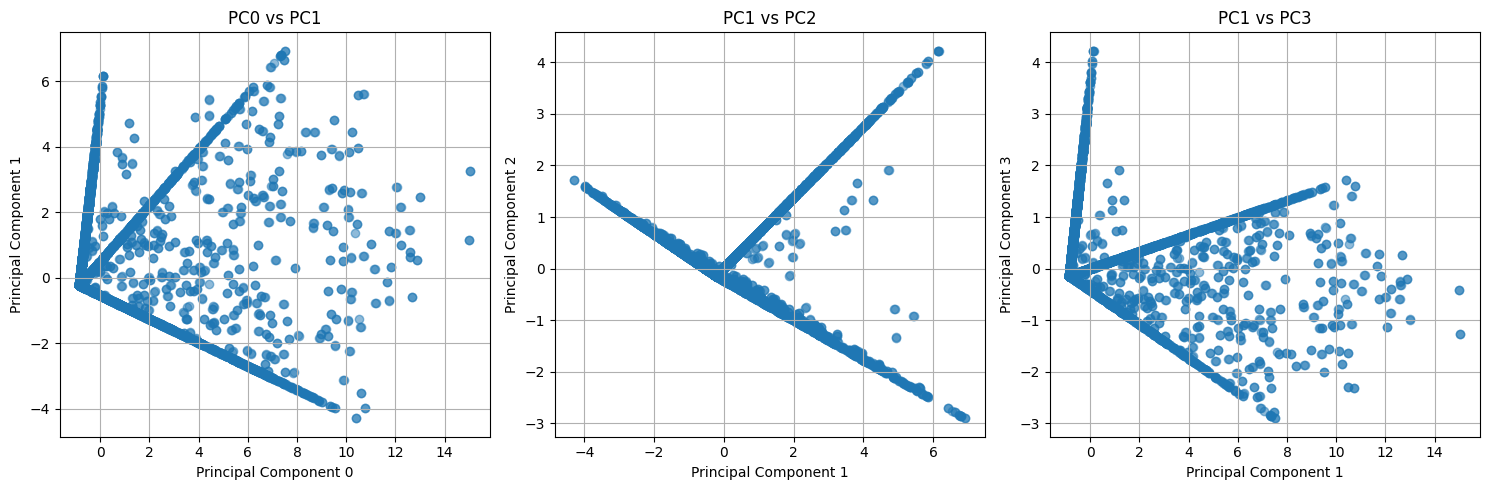

In [37]:
from sklearn.decomposition import PCA

pca = PCA()
output_pca = pca.fit_transform(reconstructions.detach().cpu().numpy())

plt.figure(figsize=(15, 5))

# Subplot 1: PC0 vs PC1
plt.subplot(1, 3, 1)
plt.scatter(output_pca[:, 0], output_pca[:, 1], alpha=0.5)
plt.title("PC0 vs PC1")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.grid()

# Subplot 2: PC1 vs PC2
plt.subplot(1, 3, 2)
plt.scatter(output_pca[:, 1], output_pca[:, 2], alpha=0.5)
plt.title("PC1 vs PC2")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()

# Subplot 3: PC1 vs PC3
plt.subplot(1, 3, 3)
plt.scatter(output_pca[:, 0], output_pca[:, 2], alpha=0.5)
plt.title("PC1 vs PC3")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 3")
plt.grid()

plt.tight_layout()
plt.show()

<BarContainer object of 10 artists>

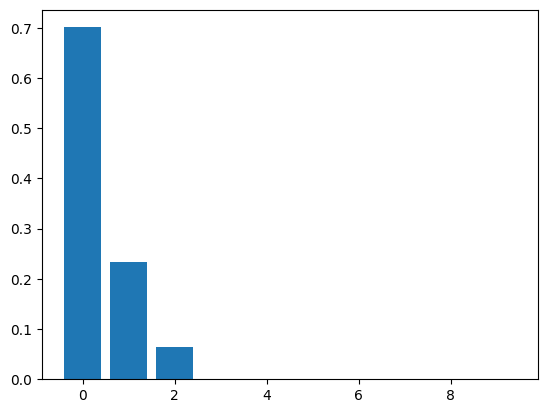

In [34]:
plt.bar(range(len(pca.explained_variance_ratio_[:10])), pca.explained_variance_ratio_[:10])